# Støt

Vi ser på to kuler som kolliderer. I vårt referansesystem kommer kule 1 inn med en hastighet $v_0 \hat{\bf x}$ fra venstre ved en høyde $h$, mens kule 2 ligger initelt i ro i origo.
Kulene har en radius $R$.
En fornuftig måte å modellere kontaktkraften dem imellom er:
$$ {\bf F}_{12} = \begin{cases}
- k \left( \left| \Delta {\bf r}_{12} \right| - 2R \right) \hat{\Delta \bf r}_{12} - \eta \Delta {\bf v}_{12} & \text{for} & \Delta {\bf r}_{12} < 2R, \\
{\bf 0} & \text{for} & \Delta {\bf r}_{12} > 2R,
\end{cases}$$
der ${\Delta \bf r}_{12} = {\bf r}_2 - {\bf r}_1$ er avstandsvektoren mellom massesentrene til de to kulene og $\Delta {\bf v}_{12} = {\bf v}_2 - {\bf v}_1$ er hastighetsforskjellen. Her er $k$ en fjærkonstant som modellerer elastisk deformasjon og $\eta$ modellerer viskøs demping.

Vi løser bevegelsesligningene (N2):
$$ \begin{align}
m_1 \frac{d^2 {\bf r}_{1}}{d t^2} &= {\bf F}_{12}, \\
m_2 \frac{d^2 {\bf r}_{2}}{d t^2} &= - {\bf F}_{12}.
\end{align}
$$


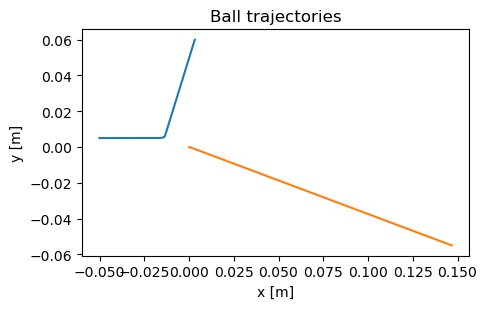

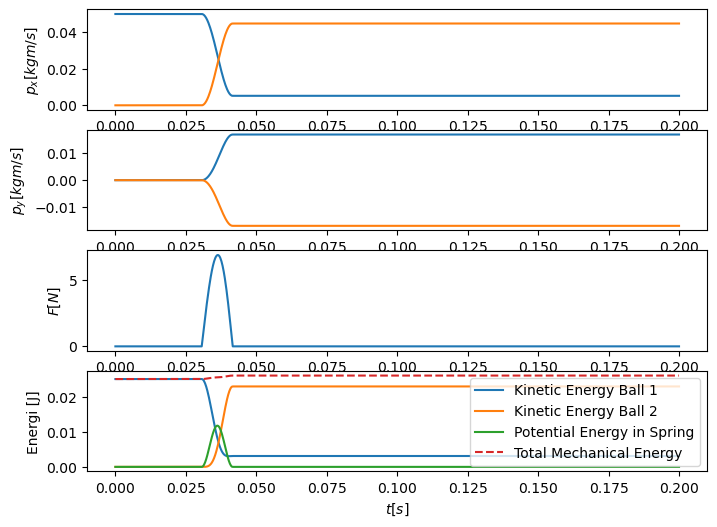

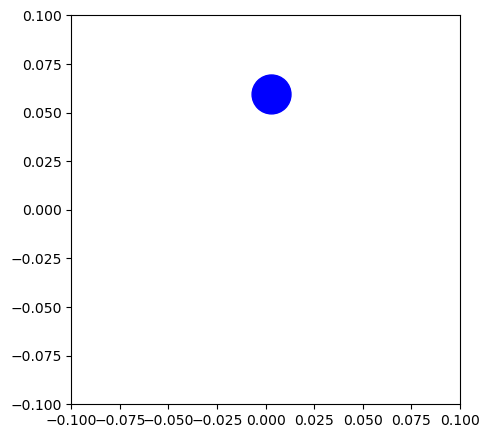

In [ ]:

import numpy as np

# definerer kraftfunksjonen mellom to partikler
def force(r1, r2, v1, v2, k, eta, R):
    dr = r2 - r1
    dv = v2 - v1
    dr_norm = np.linalg.norm(dr)
    n = dr / dr_norm
    if dr_norm < 2*R:
        F = k * (dr_norm - 2*R) * n + eta * dv
    else:
        F = np.zeros(2)
    return F

# definerer høyresiden av differensiallikningen
def rhs(t, y, k, eta, R, m1, m2):
    r1 = y[0:2]
    v1 = y[2:4]
    r2 = y[4:6]
    v2 = y[6:8]
    
    F = force(r1, r2, v1, v2, k, eta, R)
    
    dr1dt = v1
    dv1dt = F / m1
    dr2dt = v2
    dv2dt = -F / m2
    
    return np.concatenate([dr1dt, dv1dt, dr2dt, dv2dt])

# initialbetingelser
R = 0.01  # radius [m]
m1 = 0.05   # masse [kg]
m2 = 0.05   # masse [kg]
k = 2000   # fjærkonstant [N/m]
eta = 1.0  # dempningskoeffisient [kg/s]
h = 0.005     # initiell høyde partikkel 2 [m]
v0 = 1.0     # initiell hastighet partikkel 2 [m/s]
L = 0.05    # initiell avstand mellom partikler [m]
dt = 0.0001  # tidssteg [s]

r1_0 = np.array([-L, h])    # posisjon partikkel 1 [m]
v1_0 = np.array([v0, 0.0])    # hastighet partikkel 1 [m/s]
r2_0 = np.array([0.0, 0.0])   # posisjon partikkel 2 [m]
v2_0 = np.array([0.0, 0.0])   # hastighet partikkel 2 [m/s]

y0 = np.concatenate([r1_0, v1_0, r2_0, v2_0])
t_span = (0.0, 0.2)  # tidsintervall for simulering [s]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

from scipy.integrate import solve_ivp

sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, args=(k, eta, R, m1, m2), max_step=dt)
t = sol.t
y = sol.y
r1 = y[0:2, :].T
v1 = y[2:4, :].T
r2 = y[4:6, :].T
v2 = y[6:8, :].T

# beregn kontaktkraften over tid
F = np.zeros(len(t))
for i in range(len(t)):
    F_vec = force(r1[i], r2[i], v1[i], v2[i], k, eta, R)
    F[i] = np.linalg.norm(F_vec)
# beregn kinetisk energi
K1 = 0.5 * m1 * np.sum(v1**2, axis=1)
K2 = 0.5 * m2 * np.sum(v2**2, axis=1)
K_total = K1 + K2
# beregn potensiell energi lagret i fjæren
U = np.zeros(len(t))
for i in range(len(t)):
    dr = r2[i] - r1[i]
    dr_norm = np.linalg.norm(dr)
    if dr_norm < 2*R:
        U[i] = 0.5 * k * (2*R - dr_norm)**2
    else:
        U[i] = 0.0
# total mekanisk energi
E_total = K_total + U

from matplotlib import pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# plot ballenes baner
ax.plot(r1[:, 0], r1[:, 1])
ax.plot(r2[:, 0], r2[:, 1])
ax.set_aspect('equal', 'box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ball trajectories')

plt.show()

# plott bevegelsesmengde i x og y retning
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax[0].plot(t, m * v1[:, 0], label='Ball 1')
ax[0].plot(t, m * v2[:, 0], label='Ball 2')
ax[0].set_xlabel("$t [s]$")
ax[0].set_ylabel("$p_x [kg m/s]$")
ax[1].plot(t, m * v1[:, 1], label='Ball 1')
ax[1].plot(t, m * v2[:, 1], label='Ball 2')
ax[1].set_xlabel("$t [s]$")
ax[1].set_ylabel("$p_y [kg m/s]$")
ax[2].plot(t, F)
ax[2].set_xlabel("$t [s]$")
ax[2].set_ylabel("$F [N]$")
ax[3].plot(t, K1, label='Kinetic Energy Ball 1')
ax[3].plot(t, K2, label='Kinetic Energy Ball 2')
ax[3].plot(t, U, label='Potential Energy in Spring')
ax[3].plot(t, E_total, label='Total Mechanical Energy', linestyle='--')
ax[3].set_xlabel("$t [s]$")
ax[3].set_ylabel("Energi [J]")
ax[3].legend(loc='upper right')

plt.show()

# Lag animasjon av ballenes bevegelser
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100, tight_layout=True)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

# draw circles representing the balls
circle1 = plt.Circle((0, 0), R, color='b', fill=True)
circle2 = plt.Circle((0, 0), R, color='r', fill=True)
ax.add_artist(circle1)
ax.add_artist(circle2)
def init():
    circle1.center = (0, 0)
    circle2.center = (0, 0)
    return circle1, circle2,
def animate(i):
    circle1.center = (r1[i, 0], r1[i, 1])
    circle2.center = (r2[i, 0], r2[i, 1])
    return circle1, circle2,
# Plot every 10 frames
ax.set_aspect('equal', 'box')

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0, len(t), 10), interval=20, blit=True)
# save as mp4 video file
ani.save('collision.mp4', fps=30, extra_args=['-vcodec', 'libx264'])